# Car brand classification report

## Summary

1. [Introduction](#introduction)
2. [Data analysis](#dataanalysis)
    1. [Exploring the subject](#2.1)
    2. [Generating the dataset](#2.2)
    3. [Data exploration & analysis](#2.3)
3. [Data preprocessing](#datapreprocessing)
    1. [Split train & validation set](#3.1)
4. [Neural network training](#4)
    1. [Linear classification](#4.1)
    2. [Multi Layer Pereceptron](#4.2)
    3. [Support Vector Machine](#4.3)
    4. [Convolutional Neural Network](#4.4)
5. [Conclusion](#5)

<a id="introduction"></a>
## 1. Introduction

This report aims to explain how te evaluate various model for a same problematic : **Car brand prediction with an image dataset**.
We'll be exploring various models and training various one te interpret which one is the most accurate. Then we'll explain intuition that led us to several way to imrove data and therefore the **model**.


This notebook contains three four part:
* Data analysis
* Data preprocessing
* Neural networks


<a id="dataanalysis"></a>
## 2. Data analysis

This part will describe how the data was scrapped and generated and also will be explored to know the repartition of each car brand in the dataset.

<a id="2.1"></a>
### 2.1 Exploring the subject

**First approach**
First of all, in order to retrieve numerous images of a car from a specific brand we decide to create a bot to scrap google images with search such as 'audi front' or 'mercedes'.

The results were not good with too many unrevelant photos and bad quality:

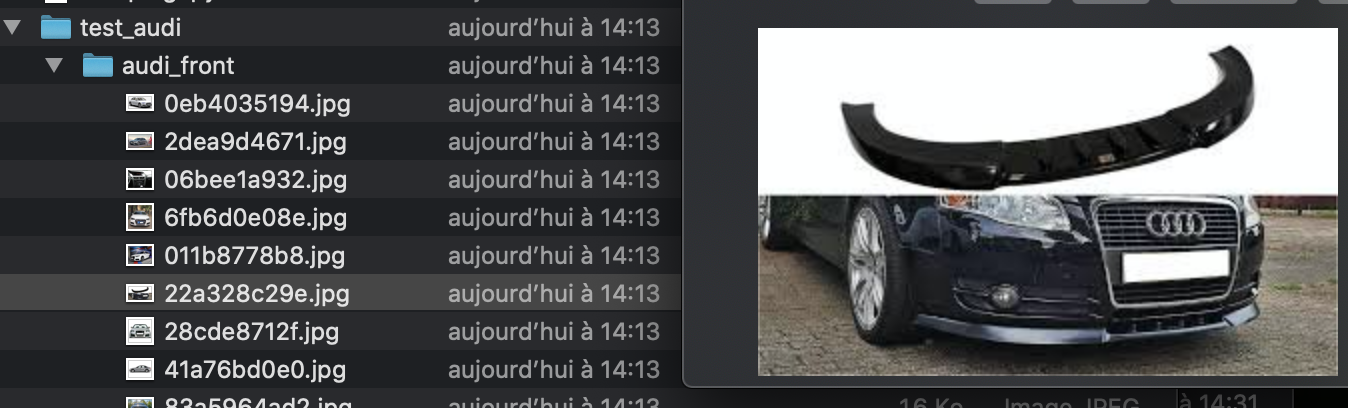

In [1]:
#
# Firstly we import necessary libs
#
import selenium
import os
import io
import time
import requests
import hashlib
from PIL import Image
from selenium import webdriver
DRIVER_PATH = '../../chromedriver' # might need a different version of chromedriver depending on OS or chrome version


#
# Fetch all images url's from a specific gogole search
#

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

#
# Utility function to save images form url in a folder
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
        
#
# Combine fetch url and save image utility functions into a more practical to use function
#

def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

# Example of usage => search_and_download('audi front', DRIVER_PATH, './dataset', 60)

<a id="2.2"></a>
### 2.2 Generating the dataset

**Second approach**

From then on we wanted to base ourselves on the images of the car ad site.
By dint of searching we found the site carizy.com which offered a strong formalised layout for pictures.
By studying the site we found that the photos were hosted on a CDN with a formalised structure for each angle (front hood).
So we set up a script to retrieve quality images on the brands we wanted with the right angle. By doing so we could iterate over brands and also over angles of the car.

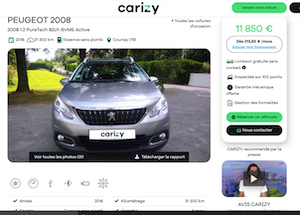

In [2]:
#
# Import necessary dependencies
#
import time
import requests
import os
import io
from PIL import Image #pip install Pillow
import hashlib

#
# Define a car data class that retrieve the useful data
#

class CarData:
    def __init__(self, car_id, url, img):
        self.car_id = car_id
        self.url = url
        self.img = img
        
    def __repr__(self):
        return str(self.car_id) + " : " + self.url + ' + ' + self.img
    
#
# Request the search api of the website with good params
#

def send_algolia_request(page):
    url = 'https://65quub6n61-dsn.algolia.net/1/indexes/*/queries?x-algolia-agent=Algolia%20for%20vanilla%20JavaScript%20(lite)%203.18.1%3Binstantsearch.js%201.8.11&x-algolia-application-id=65QUUB6N61&x-algolia-api-key=9ce4fd3eb414de32d0985b9b5a394448'
    data = {'requests': [{'indexName' : 'CarAlgoliaIndex_prod', 'params': 'query=&hitsPerPage=21&maxValuesPerFacet=100&page='+ str(page) +'&facets=%5B%22make%22%2C%22model%22%2C%22body%22%2C%22registartionDate%22%2C%22color%22%2C%22gear%22%2C%22fuel%22%2C%22price%22%2C%22monthly%22%2C%22kilometers%22%2C%22district%22%2C%22districtName%22%2C%22city%22%2C%22seats%22%2C%22isScrapPremium%22%5D&tagFilters='}]}
    p = requests.post(url, json=data)
    return p.json()

#
# map data to keep only useful data
#

def map_data(_car_data, hits):
    for e in hits:
        if e['make'] in _car_data:
            _car_data[e['make']].append(CarData(e['carId'], e['lien'], e['photo']))
        else:
            _car_data[e['make']] = [CarData(e['carId'], e['lien'], e['photo'])]

#
# Make all the request with a interval to avoid api blocking
#            
            
car_data = {}
i = 0
while i < 48:
    x = send_algolia_request(i)
    map_data(car_data, x['results'][0]['hits'])
    i += 1
    time.sleep(1)
   


#
# Utility function to download the images
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
 
#
# Final function that takes brand and angle paramaters
#

def download_brand_angle_img(brand, angle, folder):
    urls = []
    folder_url = folder
    for x in car_data[brand]:
        
        ur = x.img.replace('avant-gauche', angle)
        finalurl = 'https://cdn.carizy.com/carphotos/' + str(x.car_id) + '/wide/' + ur
        urls.append(finalurl)
    
    for z in urls:
        persist_image(folder_url, z)
        time.sleep(0.2)
# Folder must be already created
#Example of usage => download_brand_angle_img('AUDI', 'face-capot', './cars')


<div class="alert alert-block alert-info">
    We will know download raw data for three brands in the folder raw of the project structure.
</div

In [6]:
download_brand_angle_img('PEUGEOT', 'face-capot', '../../Dataset/Raw/peugeot')

SUCCESS - saved https://cdn.carizy.com/carphotos/34181/wide/peugeot-208-occasion-2013-face-capot.jpg - as ../../Dataset/Raw/peugeot/e9a67e5138.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34178/wide/peugeot-207-occasion-2009-face-capot.jpg - as ../../Dataset/Raw/peugeot/1248cc9ae4.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34159/wide/peugeot-308-sw-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/89c230f83c.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34121/wide/peugeot-2008-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/peugeot/eb0df16501.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34115/wide/peugeot-208-business-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/peugeot/0ae37dc63a.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34105/wide/peugeot-208-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/cb4c6c2ad2.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34100/wide/peugeot-3008-occasion-2015-face-capot.jpg - a

SUCCESS - saved https://cdn.carizy.com/carphotos/13540/wide/peugeot-2008-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/6a4b401514.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13522/wide/peugeot-308-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/peugeot/b6cc0518ea.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13516/wide/peugeot-2008-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/29e13d9ee0.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13493/wide/peugeot-308-cc-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/peugeot/2ef6c7f896.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13462/wide/peugeot-308-sw-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/peugeot/fb1da3aa7d.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13455/wide/peugeot-208-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/peugeot/dcecb552c1.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13434/wide/peugeot-3008-hybrid4-occasion-2012-face-capot.jpg 

SUCCESS - saved https://cdn.carizy.com/carphotos/33921/wide/peugeot-208-occasion-2019-face-capot.jpg - as ../../Dataset/Raw/peugeot/7c6e14068c.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33854/wide/peugeot-308-cc-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/peugeot/21985dd629.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33874/wide/peugeot-308-cc-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/peugeot/11d22140ff.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33848/wide/peugeot-308-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/peugeot/a64466e144.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33778/wide/peugeot-308-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/1a6ee2e55f.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/32619/wide/peugeot-308-sw-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/peugeot/4f76de5fad.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/32615/wide/peugeot-208-occasion-2016-face-capot.jpg - as ../

In [7]:
download_brand_angle_img('RENAULT', 'face-capot', '../../Dataset/Raw/renault')

SUCCESS - saved https://cdn.carizy.com/carphotos/34170/wide/renault-twingo-iii-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/renault/d6d4ce5cf6.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34165/wide/renault-twingo-ii-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/renault/319aff485d.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34109/wide/renault-twingo-ii-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/renault/5990986b51.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34158/wide/renault-captur-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/f065264b39.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34157/wide/renault-captur-occasion-2013-face-capot.jpg - as ../../Dataset/Raw/renault/ffafed7e16.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34141/wide/renault-twingo-iii-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/30f8dd49c4.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34107/wide/renault-twingo-ii-occasion

SUCCESS - saved https://cdn.carizy.com/carphotos/33843/wide/renault-twingo-ii-occasion-2008-face-capot.jpg - as ../../Dataset/Raw/renault/4b2a753403.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33841/wide/renault-zoe-occasion-2020-face-capot.jpg - as ../../Dataset/Raw/renault/e0f4b16bf8.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33834/wide/renault-clio-iv-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/renault/bbe44eb235.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33831/wide/renault-clio-iv-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/0f29174768.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33823/wide/renault-twingo-ii-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/renault/fdf3558840.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33818/wide/renault-captur-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/ed1eb73e53.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33814/wide/renault-espace-v-occasion-2015-face

SUCCESS - saved https://cdn.carizy.com/carphotos/12792/wide/renault-scenic-iii-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/renault/d753493f33.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12784/wide/renault-megane-iv-berline-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/a01a2d86b7.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12782/wide/renault-clio-iv-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/d978d63239.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12687/wide/renault-scenic-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/701935ae37.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12582/wide/renault-clio-iv-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/43e8584179.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12718/wide/renault-captur-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/e6f84fe403.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12632/wide/renault-twingo-iii-occa

SUCCESS - saved https://cdn.carizy.com/carphotos/30966/wide/renault-fluence-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/renault/64d75dc8c8.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29958/wide/renault-megane-iii-berline-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/renault/05385f695f.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29928/wide/renault-captur-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/renault/8b0069ee46.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29140/wide/renault-clio-iv-estate-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/87a7757d08.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29133/wide/renault-clio-iv-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/8abd4f6297.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/28823/wide/renault-twingo-ii-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/renault/a72aa58cf9.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/28817/wide/renault-twingo-

In [8]:
download_brand_angle_img('VOLKSWAGEN', 'face-capot', '../../Dataset/Raw/volkswagen')

SUCCESS - saved https://cdn.carizy.com/carphotos/34169/wide/volkswagen-golf-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/volkswagen/8018693f4f.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33959/wide/volkswagen-polo-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/volkswagen/0b052bc4ad.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34029/wide/volkswagen-golf-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/volkswagen/967cca70b5.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34031/wide/volkswagen-tiguan-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/volkswagen/123284bb07.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33990/wide/volkswagen-touran-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/volkswagen/f8b23173c9.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33973/wide/volkswagen-golf-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/volkswagen/81378faff0.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/32855/wide/volkswagen-t

SUCCESS - saved https://cdn.carizy.com/carphotos/29948/wide/volkswagen-tiguan-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/volkswagen/7d25477ac8.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/28386/wide/volkswagen-up-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/volkswagen/b4449584ec.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/27632/wide/volkswagen-polo-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/volkswagen/9fbcd79385.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13571/wide/volkswagen-polo-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/volkswagen/14e0fc376a.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13532/wide/volkswagen-polo-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/volkswagen/93a7d41ee4.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13446/wide/volkswagen-golf-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/volkswagen/b48c39228c.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13520/wide/volkswagen-golf-

Now we have a qualified dataset with lot of pictures ready to be trated.

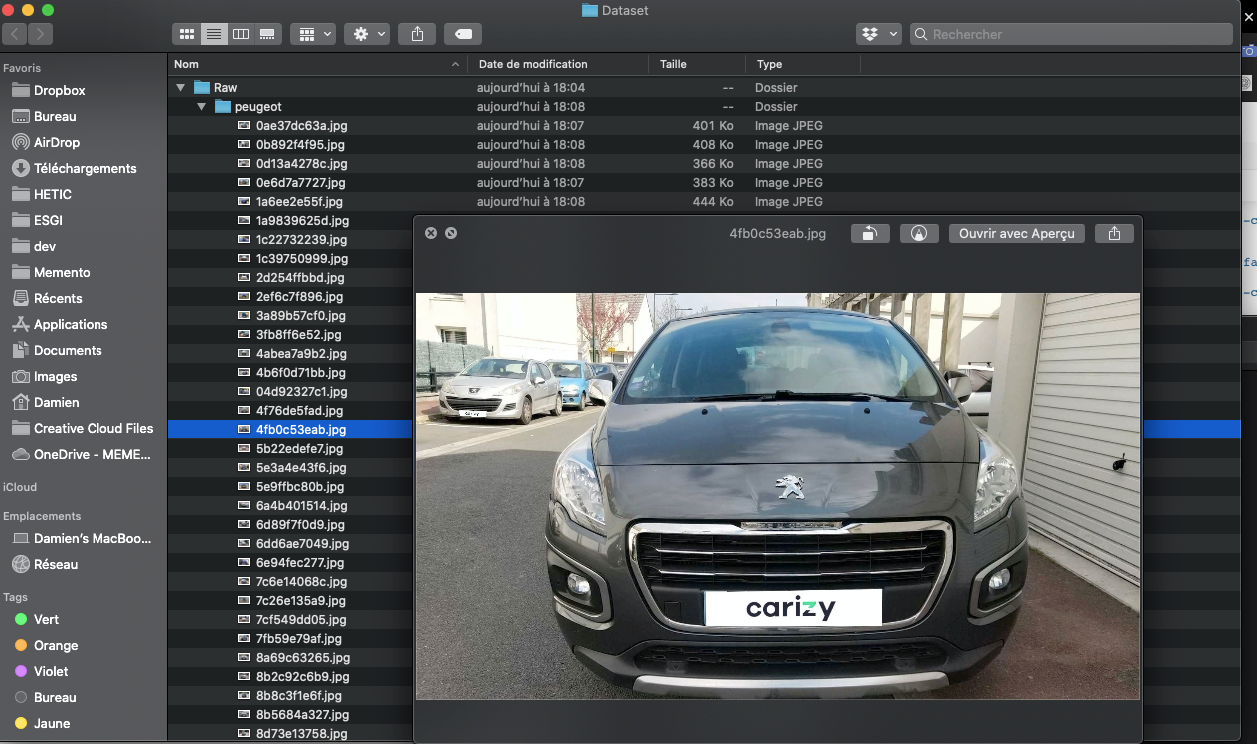

<a id="2.3"></a>
### 2.3 Data exploration & analysis

In this part we will be exploring our dataset and analyze the repartition of each brand in order to be able to evaluate the accurcay of our future model.

In [3]:
# Firstly import all important libraries even for further work
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
import tensorflow.keras.preprocessing
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
%matplotlib inline
import matplotlib.pyplot as plot
import cv2
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import pandas as pd
import imageio # pip install imageio

print('Dependencies imported')

Dependencies imported


<div class="alert alert-block alert-info">
Now, We need to prepare our data to feed into the model.
Following is the gernalized function used to extract data from the directory.
</div>

In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Peugeot, 1 for Renault, 2 for Volkswagen
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'peugeot': #Folder contain peugeot picture get label 0
            label = 0
        elif labels == 'renault':
            label = 1
        elif labels == 'volkswagen':
            label = 2

        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
            
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset

def get_classlabel(class_code):
    labels = {0:'peugeot', 1:'renault', 2:'volkswagen'}
    
    return labels[class_code]

<div class="alert alert-block alert-info">
Lets find shape of our traing data.
The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If we did not resize the images to same size. It should be (No. of images,) shape. So, using this shape we cant feed the images to the model
</div>

In [3]:
Images, Labels = get_images('../../Dataset/Raw/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)
print('Dataset loaded')#If error remove all .ds stores in project => find . -name '.DS_Store' -type f -delete

Dataset loaded


In [4]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (389, 128, 128, 3)
Shape of Labels: (389,)


<div class="alert alert-block alert-info">
So we have <strong>389</strong> pictures sized of 128 x 128 px with a 3 dimension for RGB. These are already <strong>normalized</strong> to a 128x128 matrix.<br>
Let's have a look to some random images of our dataset just for pleasure:
</div>

<div class="alert alert-block alert-info">
For any image specific classification, clustering, etc. transforms we'll want to collapse spatial dimensions so that we have a matrix of pixels by color channels.
</div>

In [5]:
first = plot.imread('../../Dataset/Raw/peugeot/0ae37dc63a.jpg')
dims = np.shape(first)
print(dims)
np.min(first), np.max(first)
# shape without redimensionning

(1080, 1920, 3)


(0, 255)

<div class="alert alert-block alert-info">
For any image specific classification, clustering, etc. transforms we'll want to collapse spatial dimensions so that we have a matrix of pixels by color channels.
</div>

(2073600, 3)


(array([[21240.,  4811.,   426., ...,     0.,     0.,     0.],
        [ 4265., 36456.,  7012., ...,     0.,     0.,     0.],
        [ 1470.,  3954., 23295., ...,     0.,     0.,     0.],
        ...,
        [    0.,     0.,     0., ...,  4939.,  4534.,  1500.],
        [    0.,     0.,     0., ...,  2841.,  8856.,  6802.],
        [    0.,     0.,     0., ...,   558.,  5571., 74550.]]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 1

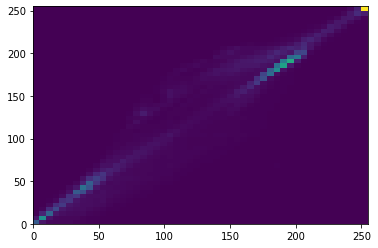

In [6]:
pixel_matrix = np.reshape(first, (dims[0] * dims[1], dims[2]))
print(np.shape(pixel_matrix))
plot.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))

<div class="alert alert-block alert-info">
Observe basic property of one image then we we will compute dataset global values. 
</div

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (1080, 1920, 3)
Image Hight 1080
Image Width 1920
Dimension of Image 3
Image size 6220800
Maximum RGB value in this image 255
Minimum RGB value in this image 0


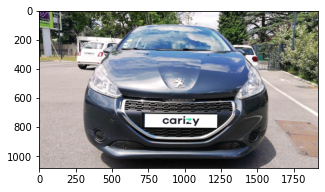

In [7]:
plot.figure(figsize = (5,5))
plot.imshow(first)
print('Type of the image : ' , type(first)) 
print('Shape of the image : {}'.format(first.shape)) 
print('Image Hight {}'.format(first.shape[0])) 
print('Image Width {}'.format(first.shape[1])) 
print('Dimension of Image {}'.format(first.ndim))
print('Image size {}'.format(first.size)) 
print('Maximum RGB value in this image {}'.format(first.max()))
print('Minimum RGB value in this image {}'.format(first.min()))  
                                                                                                              
                                                                                                                
                                                                                                                
                                                                                                              

<div class="alert alert-block alert-success">
The shape of the ndarray shows that it is a three-layered matrix. The first two numbers here are length and width, and the third number (i.e. 3) is for three layers: Red, Green, Blue. So, if we calculate the size of an RGB image, the total size will be counted as height x width x 3
</div>

<div class="alert alert-block alert-info">
Okay, now let’s take a quick view of each channel in the whole image.
</div>

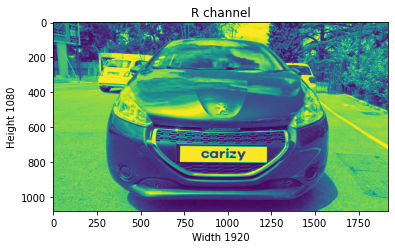

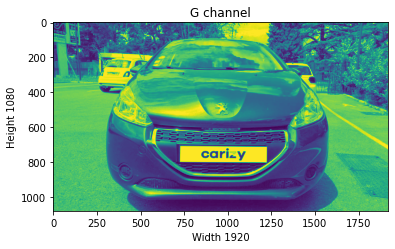

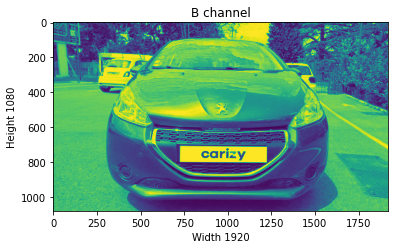

In [8]:
plot.title('R channel') 
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 0])
plot.show()
plot.title('G channel')
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 1]) 
plot.show()
plot.title('B channel') 
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 2]) 
plot.show()

**Splitting layers**
We are looking for an intersting output on a picture to see if it could be better use for model training

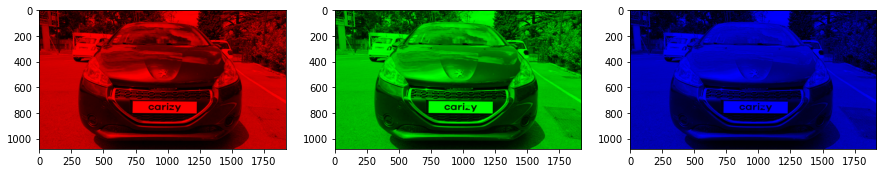

In [9]:
fig, ax = plot.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
     # create zero matrix        
     split_img = np.zeros(first.shape, dtype="uint8") 
     # 'dtype' by default: 'numpy.float64'  # assing each channel      
     split_img[ :, :, c] = first[ :, :, c] # display each channel     
     ax.imshow(split_img)

<div class="alert alert-block alert-danger">
Not very interesting. Maybe we could look for a grayscale image. It coulb be used later for computational matters. 
</div>

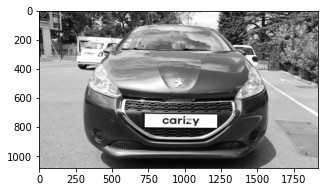

In [10]:
gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
gray = gray(first)
plot.figure( figsize = (5,5))  
plot.imshow(gray, cmap = plot.get_cmap(name = 'gray')) 
plot.show()

<div class="alert alert-block alert-info">
The car brand is still recognizable and the logo also. Moreover it reduces the dimension of the np array and it could be a clear advantage to train the model.
</div

<div class="alert alert-block alert-info">
Let's visualize a few image of the dataset just for pleasure.
</div

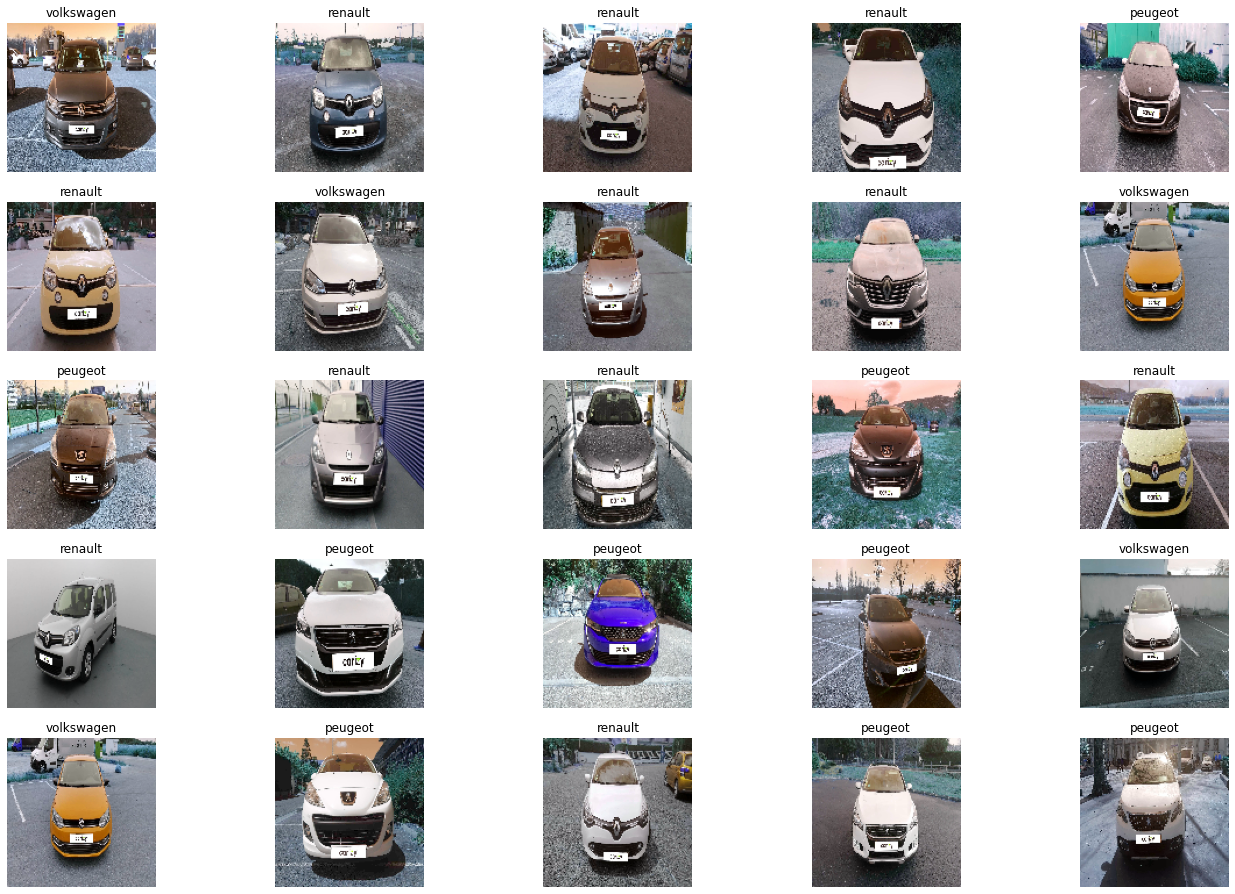

In [11]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(5):
    for j in range(5):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

**Data exploration**
We are now going to visualize the repartition of each car brand with a bar and scatter chart.

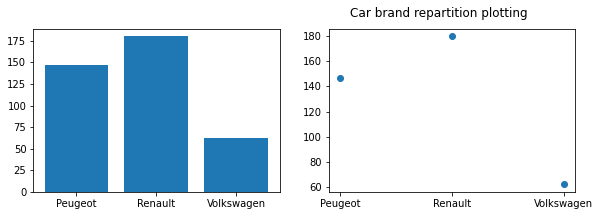

Peugeot : 147 | 37.78%
Renault : 180 | 46.27%
Volkswagen : 62 | 15.93%


In [12]:
unique, counts = np.unique(Labels, return_counts=True)
occurences = np.asarray((unique, counts)).T
names = ['Peugeot', 'Renault', 'Volkswagen']
values = [occurences[0][1], occurences[1][1], occurences[2][1]]
total = Labels.size
plot.figure(figsize=(15, 3))

plot.subplot(131)
plot.bar(names, values)
plot.subplot(132)
plot.scatter(names, values)
plot.suptitle('Car brand repartition plotting')
plot.show()
print("Peugeot : " + str(occurences[0][1]) + " | " + str(int(occurences[0][1] / total * 10000) / 100) + "%")
print("Renault : " + str(occurences[1][1]) + " | " + str(int(occurences[1][1] / total * 10000) / 100) + "%")
print("Volkswagen : " + str(occurences[2][1]) + " | " + str(int(occurences[2][1] / total * 10000) / 100) + "%")


<div class="alert alert-block alert-success">
Regarding those results we are now able to estimate our model efficiency.<br>
If the model predict peugeot less than the random (46.5%) then it won't be good enough. Since it could be prediciting renault each time.
</div>

<a id="datapreprocessing"></a>
## 3. Data pre-processing

Since we have already loaded the data in the Images class and the dataset was already normliazed to 128x128 matrix we will the validation and train set and then label encode the data.

<a id="3.1"></a>
### 3.1 Split training & validation set


<div class="alert alert-block alert-success">
I choosed to split the train set in two parts : a small fraction (20%) became the validation set which the model is evaluated and the rest (80%) is used to train the model. This the safest and classical splitting values.<br>
Moreover i will take <strong>10 pictures</strong> in each brand dataset to put it in a test set directly in the folders.
</div>

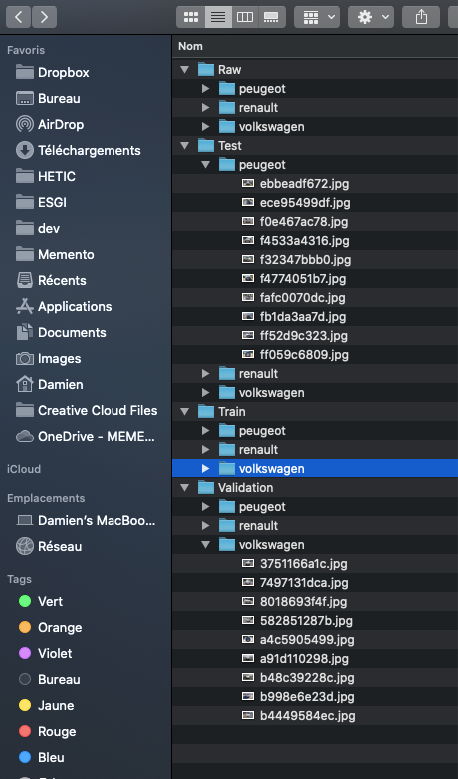

In [13]:
# parameters variable

train_dir = "../../Dataset/Train"
validation_dir = "../../Dataset/Validation"
target_width = 128
target_height = 128
color_mode = 'rgb'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255)

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
    )
#set Validation data
validation_data = image_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode
)

train_data.batch_size = train_data.n
(x, y) = train_data.next()
train_true_label = np.argmax(y, axis=1)

Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


<div class="alert alert-block alert-info">
    Perfec the dataset is loaded and and resized to 128x128 pictures
</div>

<a id="4"></a>
## 4. Neural networks training

We are now going to start training our first neural network by using three different models:
* Linear Model
* Multi Layer Perceptron
* Support Vector machine
* Convolutional Neural Network

In [4]:
# Necessary classes for building a correct model and neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

<a id="4.1"></a>
### 4.1 Linear Model

We are now going to build the linear classfication model which will be represented by neural network without any hidden layer.

In [46]:

train_dir = "../../Dataset/Train/"
validation_dir = "../../Dataset/Validation/"
target_width = 128
target_height = 128
color_mode = 'rgb'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255)

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
    )
#set Validation data
validation_data = image_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode)

Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


In [47]:
linear_model = Sequential()
linear_model.add(Flatten(input_shape=(128,128,3)))
linear_model.add(Dense(3))
linear_model.add(Activation('softmax'))

linear_model.compile(optimizer='SGD',
              loss=tensorflow.keras.losses.mean_squared_error,
              metrics=['accuracy'])
linear_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 147459    
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
Total params: 147,459
Trainable params: 147,459
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Train the model
history = linear_model.fit(train_data, epochs=50, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/final_linear")])

Epoch 1/50
10/10 [==============================] - 11s 1s/step - loss: 0.3537 - accuracy: 0.4671 - val_loss: 0.3429 - val_accuracy: 0.4857
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 0.3529 - accuracy: 0.4706 - val_loss: 0.3429 - val_accuracy: 0.4857
Epoch 3/50
10/10 [==============================] - 12s 1s/step - loss: 0.3529 - accuracy: 0.4706 - val_loss: 0.3429 - val_accuracy: 0.4857
Epoch 4/50
10/10 [==============================] - 10s 1s/step - loss: 0.3529 - accuracy: 0.4706 - val_loss: 0.3429 - val_accuracy: 0.4857
Epoch 5/50
10/10 [==============================] - 10s 1s/step - loss: 0.3529 - accuracy: 0.4706 - val_loss: 0.3429 - val_accuracy: 0.4857
Epoch 6/50
10/10 [==============================] - 11s 1s/step - loss: 0.3529 - accuracy: 0.4706 - val_loss: 0.3429 - val_accuracy: 0.4857
Epoch 7/50
10/10 [==============================] - 10s 1s/step - loss: 0.3529 - accuracy: 0.4706 - val_loss: 0.3429 - val_accuracy: 0.4857
Epoch 8/50
10/10 [==

In [49]:
linear_model.save('../../App/backend/models/linear_model.h5')

In [28]:
#utility function to show loss in interactive plot
%matplotlib notebook
import matplotlib.pyplot as plot
def plot_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plot.legend()
    plot.grid()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


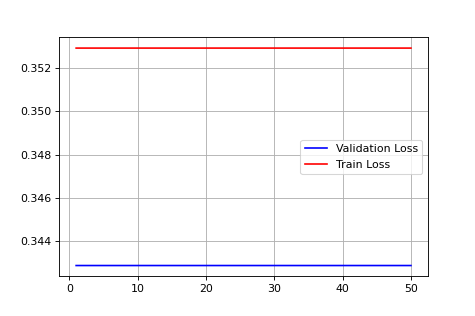

In [36]:
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Mean Squared Error Loss"
x= list(range(1, 50+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

In [38]:
 train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = linear_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = linear_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(metrics.confusion_matrix(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(metrics.confusion_matrix(validation_true_label, validation_preds_label))

Training Set Confusion Matrix : 
[[  0 110   0]
 [  0 136   0]
 [  0  43   0]]
Validation Set Confusion Matrix : 
[[ 0 27  0]
 [ 0 34  0]
 [ 0  9  0]]


<div class="alert alert-block alert-danger">
    The model is converging too fast to full Renault recognition. We need a more complex neural network. 
</div>

<a id="4.2"></a>
### 4.2 Multi Layer Pereceptron

Let's try now with a second type of neural network. We hope for better results.
We will be able tu use the same validation and training set in order to compare the results.

In [42]:
# Build basic MLP model
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(128,128,3)))
mlp_model.add(Dense(128, activation='tanh'))
mlp_model.add(Dense(128, activation='tanh'))
mlp_model.add(Dense(3, activation='softmax'))
mlp_model.compile(loss=tensorflow.keras.losses.mean_squared_error, metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 387       
Total params: 6,308,483
Trainable params: 6,308,483
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Train the model
history = mlp_model.fit(train_data, epochs=50, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/basic_mlp_128x128_rgb_MSErr")])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.3048 - accuracy: 0.1488 - val_loss: 0.2067 - val_accuracy: 0.4857
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2151 - accuracy: 0.4706 - val_loss: 0.3525 - val_accuracy: 0.3857
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.3564 - accuracy: 0.3806 - val_loss: 0.2208 - val_accuracy: 0.4857
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 0.2287 - accuracy: 0.4706 - val_loss: 0.2970 - val_accuracy: 0.3857
Epoch 5/50
1/1 [==============================] - 4s 4s/step - loss: 0.3014 - accuracy: 0.3806 - val_loss: 0.2404 - val_accuracy: 0.4857
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 0.2489 - accuracy: 0.4706 - val_loss: 0.2332 - val_accuracy: 0.3857
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 0.2387 - accuracy: 0.3806 - val_loss: 0.2468 - val_accuracy: 0.4857
Epoch 8/50
1/1 [=========================

<IPython.core.display.Javascript object>


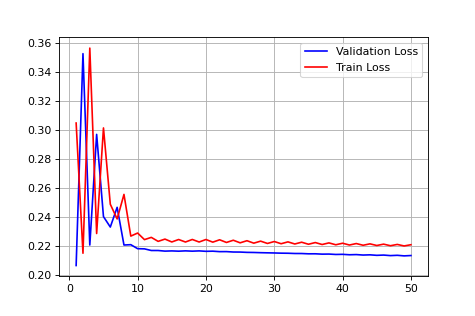

In [44]:
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Mean Squared Error Loss"
x= list(range(1, 50+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

In [45]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = linear_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = linear_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(metrics.confusion_matrix(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(metrics.confusion_matrix(validation_true_label, validation_preds_label))

Training Set Confusion Matrix : 
[[  0 110   0]
 [  0 136   0]
 [  0  43   0]]
Validation Set Confusion Matrix : 
[[ 0 27  0]
 [ 0 34  0]
 [ 0  9  0]]


<div class="alert alert-block alert-danger">
    The model is underfitting and does not learn we want to try with a greyscale dataset since color can be a bad thing for features extraction for the model.
</div>

<div class="alert alert-block alert-info">
The computing is too long so we want to try reduce the input size. Treating data in greyscale seems a good idea. The feature of a car brand is not in it's color but more in it it's shape. In addition since we don't have every car color the coloration can give the models bad intuitions on color.
</div>

In [46]:
#Let's generate the grayscale dataset
train_dir = "../../Dataset/Train"
validation_dir = "../../Dataset/Validation"
target_width = 128
target_height = 128
color_mode = 'grayscale'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255)

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
        #classes=['peugeot', 'renault', 'volkswagen']
    )
#set Validation data
validation_data = image_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode
    #classes=['peugeot', 'renault', 'volkswagen']
)

train_data.batch_size = train_data.n
(x, y) = train_data.next()
train_true_label = np.argmax(y, axis=1)
print(train_data.next()[0].shape)

Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.
(289, 128, 128, 1)


In [47]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(128,128, 1)))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(3, activation='softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/mlp_m.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
mlp_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 387       
Total params: 8,553,731
Trainable params: 8,553,731
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = mlp_model.fit(train_data, batch_size = 32, epochs=50, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/triple512_sgd_relu_simple_mlp_greyscale_categorical-crossentropy"), checkpoint])

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.4844
Epoch 00001: val_accuracy improved from -inf to 0.38571, saving model to ../../App/backend/models/mlp_m.h5
1/1 [==============================] - 3s 3s/step - loss: 1.0320 - accuracy: 0.4844 - val_loss: 1.0715 - val_accuracy: 0.3857
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.3910
Epoch 00002: val_accuracy improved from 0.38571 to 0.48571, saving model to ../../App/backend/models/mlp_m.h5
1/1 [==============================] - 3s 3s/step - loss: 1.0411 - accuracy: 0.3910 - val_loss: 1.5097 - val_accuracy: 0.4857
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 1.5509 - accuracy: 0.4706
Epoch 00003: val_accuracy did not improve from 0.48571
1/1 [==============================] - 3s 3s/step - loss: 1.5509 - accuracy: 0.4706 - val_loss: 1.1971 - val_accuracy: 0.3857
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 1.1659 -

Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: 0.8741 - accuracy: 0.4775
Epoch 00031: val_accuracy did not improve from 0.48571
1/1 [==============================] - 3s 3s/step - loss: 0.8741 - accuracy: 0.4775 - val_loss: 1.0356 - val_accuracy: 0.4143
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.4879
Epoch 00032: val_accuracy did not improve from 0.48571
1/1 [==============================] - 3s 3s/step - loss: 0.8710 - accuracy: 0.4879 - val_loss: 1.0298 - val_accuracy: 0.4857
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: 0.8592 - accuracy: 0.4948
Epoch 00033: val_accuracy did not improve from 0.48571
1/1 [==============================] - 3s 3s/step - loss: 0.8592 - accuracy: 0.4948 - val_loss: 1.0113 - val_accuracy: 0.4429
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.5917
Epoch 00034: val_accuracy did not improve from 0.48571
1/1 [=========================

<IPython.core.display.Javascript object>


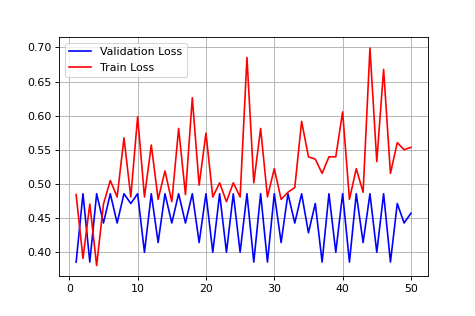

<IPython.core.display.Javascript object>


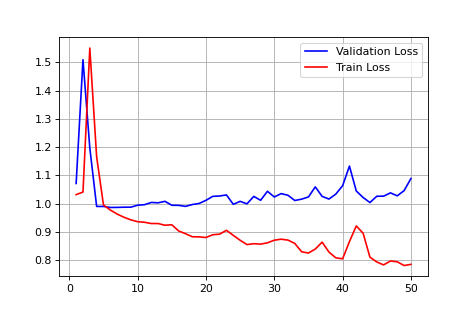

In [49]:
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Mean Squared Error Loss"
x= list(range(1, 50+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plot_dynamic(x, vy, ty, ax)

#Loss
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Mean Squared Error Loss"
x= list(range(1, 50+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

In [51]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = mlp_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = mlp_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(CM(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(CM(validation_true_label, validation_preds_label))

Training Set Confusion Matrix : 
[[  1 108   1]
 [  0 136   0]
 [  0  25  18]]
Validation Set Confusion Matrix : 
[[ 0 26  1]
 [ 0 32  2]
 [ 0  9  0]]


In [ ]:
<div class="alert alert-block alert-info">
Since the dataset is not large enough (389 images) for 3 classes with lot of paramaters we awill try produce data augmentation to get better results than random (46%) here.
</div>

## Data augmentation
In order to improve the datset that is not big enough for geenralization we will proceed to data augmentation:
* First we will change the zoom on each image since usually the center of the image is where the car is situated
* Then we will proceed to horizontal flip since it is not changing the car features
* A few degrees rotation won't change the brand features neither
* Will shift the image horizontally and vertically in order to create better strengh to the model

In [33]:
#Let's generate the augmented dataset
train_dir = "../../Dataset/Train"
validation_dir = "../../Dataset/Validation"
target_width = 128
target_height = 128
color_mode = 'grayscale'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.30,#Zooming
                                     horizontal_flip=True,
                                     rotation_range=10,
                                     width_shift_range=0.2, #Horizontal shifting
                                     height_shift_range=0.2)#vertical shifting

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
        #classes=['peugeot', 'renault', 'volkswagen']
    )
#set Validation data
validation_data = image_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode
    #classes=['peugeot', 'renault', 'volkswagen']
)

train_data.batch_size = train_data.n
(x, y) = train_data.next()
train_true_label = np.argmax(y, axis=1)


Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


In [34]:
# Now that we have augmented the datset let's create the model
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(128,128, 1)))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(3, activation='softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/mlp_mod.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
mlp_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])
mlp_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 1539      
Total params: 8,915,971
Trainable params: 8,915,971
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = mlp_model.fit(train_data, batch_size = 32, epochs=100, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/mlp_fin"), checkpoint])



Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.3979
Epoch 00001: val_accuracy improved from -inf to 0.48571, saving model to ../../App/backend/models/mlp_mod.h5
1/1 [==============================] - 3s 3s/step - loss: 1.0528 - accuracy: 0.3979 - val_loss: 1.0421 - val_accuracy: 0.4857
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.0857 - accuracy: 0.4706
Epoch 00002: val_accuracy did not improve from 0.48571
1/1 [==============================] - 3s 3s/step - loss: 1.0857 - accuracy: 0.4706 - val_loss: 1.1724 - val_accuracy: 0.3857
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.3806
Epoch 00003: val_accuracy did not improve from 0.48571
1/1 [==============================] - 3s 3s/step - loss: 1.1773 - accuracy: 0.3806 - val_loss: 1.0698 - val_accuracy: 0.4857
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.1118 - accuracy: 0.4706
Epoch 00004: val_accuracy did n

Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.9974 - accuracy: 0.4671
Epoch 00060: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 0.9974 - accuracy: 0.4671 - val_loss: 1.0123 - val_accuracy: 0.4286
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.9856 - accuracy: 0.4844
Epoch 00061: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 0.9856 - accuracy: 0.4844 - val_loss: 0.9952 - val_accuracy: 0.4714
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.9740 - accuracy: 0.4740
Epoch 00062: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 0.9740 - accuracy: 0.4740 - val_loss: 0.9854 - val_accuracy: 0.4714
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.9909 - accuracy: 0.4775
Epoch 00063: val_accuracy did not improve from 0.52857
1/1 [=====================

Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.9808 - accuracy: 0.5260
Epoch 00090: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 0.9808 - accuracy: 0.5260 - val_loss: 0.9941 - val_accuracy: 0.5429
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.9742 - accuracy: 0.4913
Epoch 00091: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 0.9742 - accuracy: 0.4913 - val_loss: 0.9862 - val_accuracy: 0.4714
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.5225
Epoch 00092: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 0.9682 - accuracy: 0.5225 - val_loss: 1.0113 - val_accuracy: 0.4714
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.9859 - accuracy: 0.4671
Epoch 00093: val_accuracy did not improve from 0.55714
1/1 [=====================

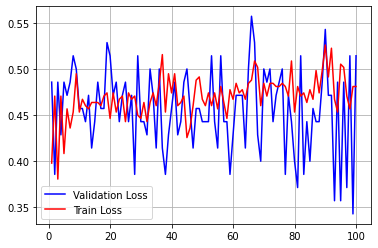

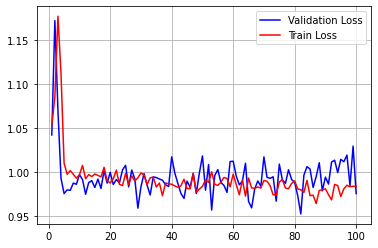

In [41]:
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Accurcay"
x= list(range(1, 100+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plot_dynamic(x, vy, ty, ax)

#Loss
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Categorical crossentropy Loss"
x= list(range(1, 100+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

In [38]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = mlp_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = mlp_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(CM(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(CM(validation_true_label, validation_preds_label))

Training Set Confusion Matrix : 
[[  8 102   0]
 [  9 127   0]
 [  1  42   0]]
Validation Set Confusion Matrix : 
[[ 1 26  0]
 [ 0 34  0]
 [ 1  8  0]]


<div class="alert alert-block alert-success">
We have reached a 55% accuracy on the validation which is slightly better than random. The model predict too much Renault according the confusion matrices. That is due to its over representation in the dataset.
</div>

<a id="4.3"></a>
### 4.3 Support Vector Machine

We don't have good enough result will try adding a SVM (regulizer in Keras) to improve the model and reduce overfitting

In [12]:
# Now that we have augmented the datset let's create the model
svm_model = Sequential()

svm_model.add(Flatten(input_shape=(128,128, 1)))
svm_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))# Kernel Regulizer is common Support Vector Machine Implementation in Keras
svm_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
svm_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
svm_model.add(Dense(3, activation='softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/svm_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
svm_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.mean_squared_error, metrics=['categorical_accuracy', 'accuracy'])
svm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 1539      
Total params: 8,915,971
Trainable params: 8,915,971
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = svm_model.fit(train_data, batch_size = 32, epochs=50, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/svm_triple512"), checkpoint])


Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 20.4940 - categorical_accuracy: 0.1488 - accuracy: 0.1488
Epoch 00001: val_accuracy improved from -inf to 0.48571, saving model to ../../App/backend/models/svm_model.h5
1/1 [==============================] - 3s 3s/step - loss: 20.4940 - categorical_accuracy: 0.1488 - accuracy: 0.1488 - val_loss: 20.3941 - val_categorical_accuracy: 0.4857 - val_accuracy: 0.4857
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 20.3977 - categorical_accuracy: 0.4048 - accuracy: 0.4048
Epoch 00002: val_accuracy did not improve from 0.48571
1/1 [==============================] - 3s 3s/step - loss: 20.3977 - categorical_accuracy: 0.4048 - accuracy: 0.4048 - val_loss: 20.3780 - val_categorical_accuracy: 0.4857 - val_accuracy: 0.4857
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 20.3753 - categorical_accuracy: 0.4602 - accuracy: 0.4602
Epoch 00003: val_accuracy improved from 0.48571 to 0.50000, saving model t

Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: 20.0303 - categorical_accuracy: 0.4844 - accuracy: 0.4844
Epoch 00044: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 20.0303 - categorical_accuracy: 0.4844 - accuracy: 0.4844 - val_loss: 20.0256 - val_categorical_accuracy: 0.4286 - val_accuracy: 0.4286
Epoch 45/50
1/1 [==============================] - ETA: 0s - loss: 20.0208 - categorical_accuracy: 0.4602 - accuracy: 0.4602
Epoch 00045: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 20.0208 - categorical_accuracy: 0.4602 - accuracy: 0.4602 - val_loss: 20.0207 - val_categorical_accuracy: 0.4429 - val_accuracy: 0.4429
Epoch 46/50
1/1 [==============================] - ETA: 0s - loss: 20.0143 - categorical_accuracy: 0.4775 - accuracy: 0.4775
Epoch 00046: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 20.0143 - cate

<IPython.core.display.Javascript object>


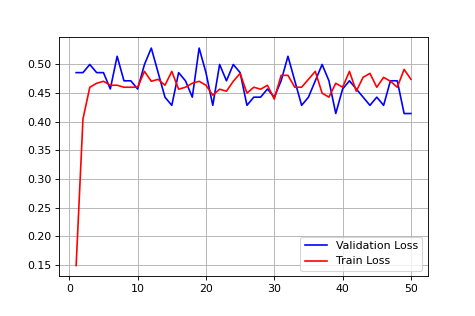

<IPython.core.display.Javascript object>


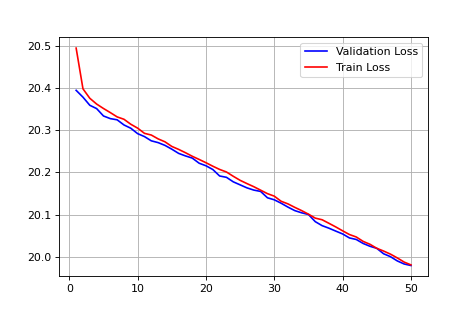

In [14]:
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Accuracy"
x= list(range(1, 50+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plot_dynamic(x, vy, ty, ax)

#Loss
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Mean Squarred Error"
x= list(range(1, 50+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

In [16]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = svm_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = svm_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(CM(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(CM(validation_true_label, validation_preds_label))

Training Set Confusion Matrix : 
[[ 25  85   0]
 [ 15 121   0]
 [  5  38   0]]
Validation Set Confusion Matrix : 
[[ 5 22  0]
 [ 5 29  0]
 [ 2  7  0]]


<div class="alert alert-block alert-info">
The model has reach a 53% accuracy.
</div>

<a id="4.4"></a>
### 4.4 Convolutional Neural Network

The most efficient model for computer vision is know as convolutional neural network which will try to train to get some results.

In [25]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01)

cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', activation ='relu',input_shape=((128,128,1))))
cnn_model.add(MaxPool2D())

cnn_model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn_model.add(MaxPool2D())

# the model so far outputs 3D feature maps (height, width, features)
#On top of it we stick two fully-connected layers. We end the model with a single 

cnn_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
cnn_model.add(Dense(3))
cnn_model.add(Activation('softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/cnn_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
cnn_model.compile(optimizer=opt, loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])
cnn_model.summary()






Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [42]:
#Proper epoch would be 50
history = cnn_model.fit_generator(train_data, epochs=20, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/cnn_fin"), checkpoint])


Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.4671
Epoch 00001: val_accuracy did not improve from 0.55714
1/1 [==============================] - 4s 4s/step - loss: 1.0056 - accuracy: 0.4671 - val_loss: 0.9802 - val_accuracy: 0.4857
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.0052 - accuracy: 0.4706
Epoch 00002: val_accuracy did not improve from 0.55714
1/1 [==============================] - 4s 4s/step - loss: 1.0052 - accuracy: 0.4706 - val_loss: 0.9771 - val_accuracy: 0.4857
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 1.0010 - accuracy: 0.4671
Epoch 00003: val_accuracy did not improve from 0.55714
1/1 [==============================] - 4s 4s/step - loss: 1.0010 - accuracy: 0.4671 - val_loss: 0.9838 - val_accuracy: 0.4857
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 1.0012 - accuracy: 0.4706
Epoch 00004: val_accuracy did not improve from 0.55714
1/1 [=============================

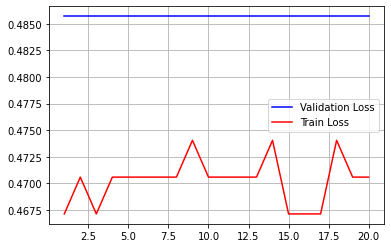

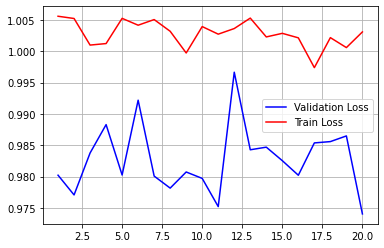

In [43]:
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Accuracy"
x= list(range(1, 20+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plot_dynamic(x, vy, ty, ax)

#Loss
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Categorical crossentropy Loss"
x= list(range(1, 20+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

In [45]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = cnn_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = cnn_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(CM(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(CM(validation_true_label, validation_preds_label))

Training Set Confusion Matrix : 
[[  1 109   0]
 [  1 135   0]
 [  0  43   0]]
Validation Set Confusion Matrix : 
[[ 0 27  0]
 [ 0 34  0]
 [ 1  8  0]]


<div class="alert alert-block alert-danger">
After trying many optimizers I can"t manage to make validation not be in stagnation on learning. 55% is best I managed to get.
</div>

<a id="5"></a>
## 5. Conclusion

To conclude the results are not really good. The best model is doing slightly better than random.
Each are each model results:
* Linear model : **46%**
* Multi Layer Perceptron : **55%**
* Support Vector Machine : **53%**
* Convolutional Neural network : **55%**

The applicative problem had many difficulties:
* Each car brand has very different features depending on year, model, finition, color etc
* Computing is long for such images
* The angle of the photos were limites
* A better approach would have been to use a object detection Algorithm such as **YOLO** and then build a model for logo recognition which would have way more accurate. The dataset would have been easier to build and it would have been easier to add new brands which is the goal of a such application.